

---
**Project title: BLACKJACK**

*Author: Damian Wróbel*

---


**Introduction**: Blackjack is a popular card game (sth like "oczko" in PL) where player collect cards to achieve total value closer to 21 than dealer. If sum of cards is greater than 21, player (or dealer) loses.

**Methods**: NN will learn to play versus dealer. There will be used gym Blackjack-v1 environment and kreas actor-critic model. Project consists of two parts. In the first part the model is build and trained to achieve satisfactional results. Then model is saved and imported in the second part of project where model is trained with different learning rate to improve results and control learning process. Finaly, the decision matrix is presented and win ratio is calculated.

**Results**: Achieved win ratio is close to win ratio of basic optimal strategy in blackjack game.

**Conclusions**: Presented machine learning model is able to learn from nothing how to play blackjack and can achieve satisfactional results.

---



Import of libraries:

- gym - for blackjack environment
- numpy - for preparing data to visualise
- tensorflow - for machine learning
- matplotlib - for visualising data


In [ ]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt



Creating Blackjack environment.

Environment gives 3 information: player sum of values, dealer sum of values and true/false info about ace in players cards

In [ ]:
env = gym.make('Blackjack-v1')  # Create the environment
env.reset()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


(20, 4, False)

Building the model.

- number of inputs = 3 -> as described above (player value, dealer value, ace info)
- number of actions = 2 -> player can pass (if he doesn't need addidional cards) or play (when he wants one additional card)
- number of hidden layers = 16 -> this walue was changing during project, finally the value of 16 was enough to train the network

The actor - critic mechanism was used.

In [ ]:
num_inputs = 3    # 3 parameters describing the state
num_actions = 2   # pass or play
num_hidden = 16

inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="softmax")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

Optimizer Adam was used with learning rate = 0.01 to achieve first results. With this LR the network was changing conception of optimal decisions what can be see in decision plots. In second part the learning rate was smaller.

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

X=[]
Y=[]
i=0
def res(x,y):
    stan=[x,y,0]
    stan = tf.convert_to_tensor(stan)
    stan = tf.expand_dims(stan, 0)
    probs,ac=model(stan)
    return float(probs[0][0])

Model if working till satisfactional running rewards. Formulas presented at lecture was used with some adjustations:
- parts of code which has to visualise progress was identyfied and omited
- each run has up to 3 decision (if the game was not finish earlier)
- each 500 runs running reward and decision plots are printed

running reward: -0.68 at episode 500
0.0
0.0


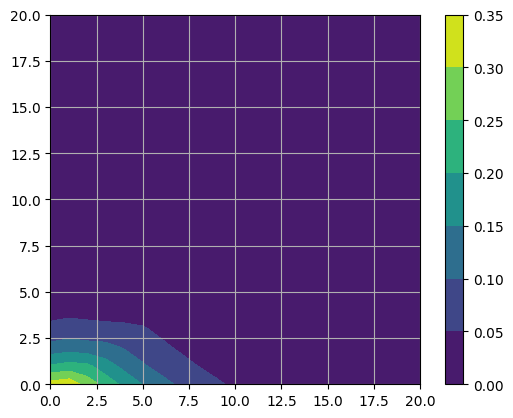

running reward: -0.75 at episode 1000
0.0
0.0


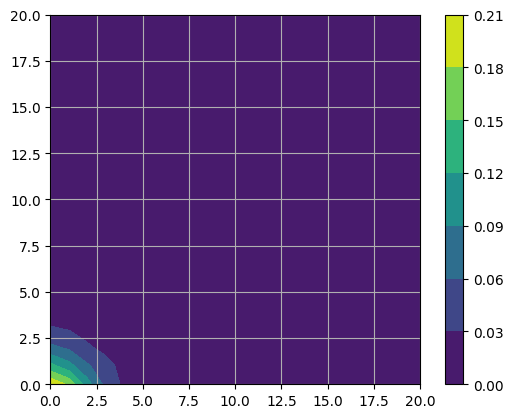

running reward: -0.84 at episode 1500
0.0
0.0


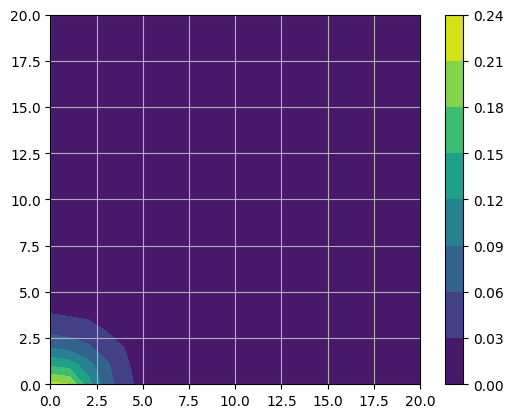

running reward: -0.93 at episode 2000
0.0
0.0


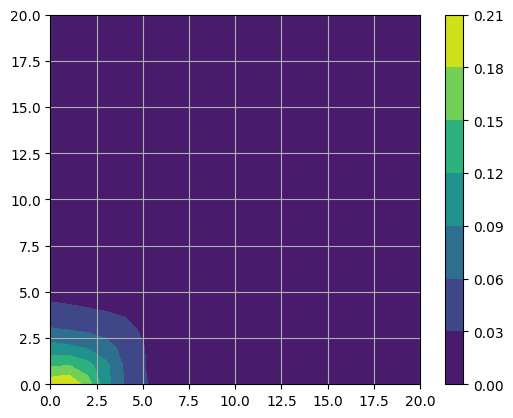

running reward: -0.79 at episode 2500
0.0
0.0


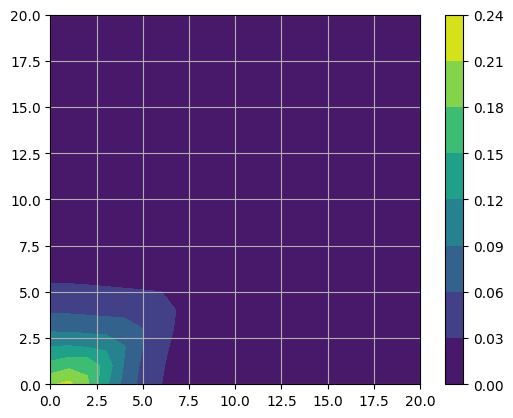

running reward: -0.59 at episode 3000
0.0
0.0


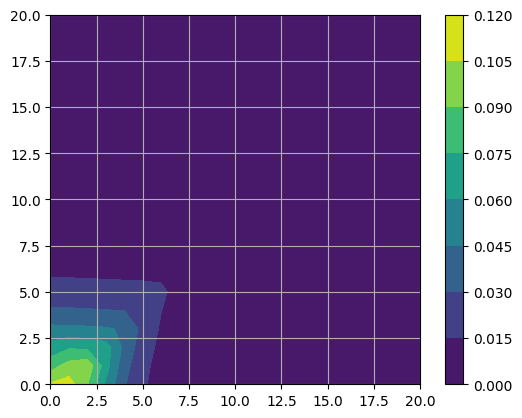

running reward: -0.82 at episode 3500
0.0
0.01


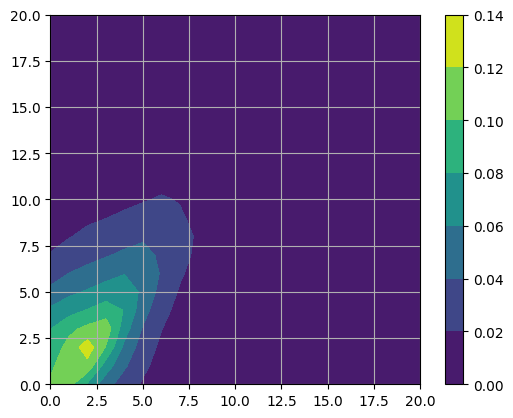

running reward: -0.69 at episode 4000
0.0
0.0


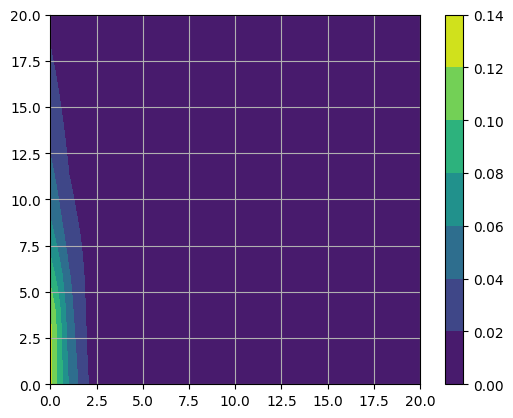

running reward: -0.79 at episode 4500
0.0
0.0


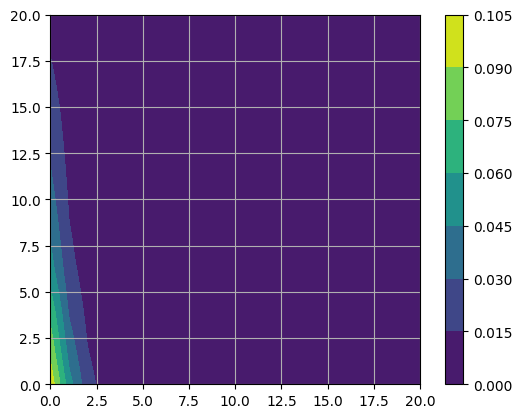

running reward: -0.84 at episode 5000
0.0
0.0


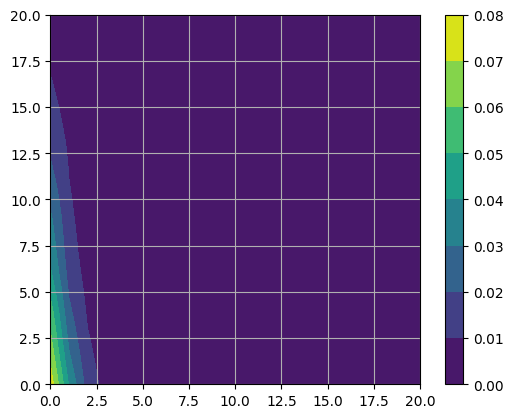

running reward: -0.63 at episode 5500
0.0
0.0


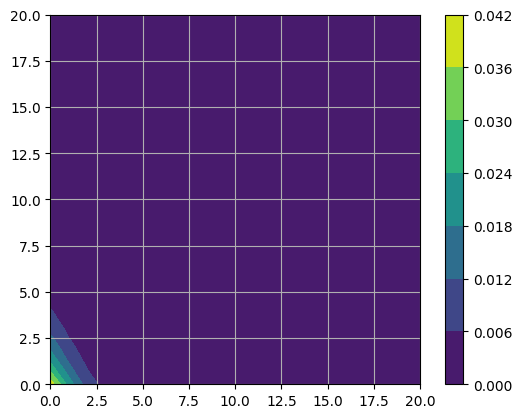

running reward: -0.90 at episode 6000
0.0
0.0


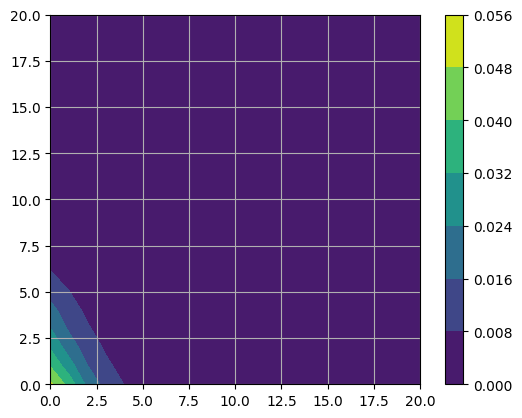

running reward: -0.25 at episode 6500
0.47
0.26


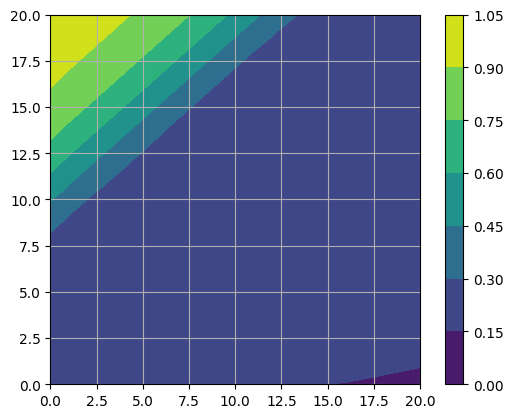

running reward: -0.20 at episode 7000
1.0
0.89


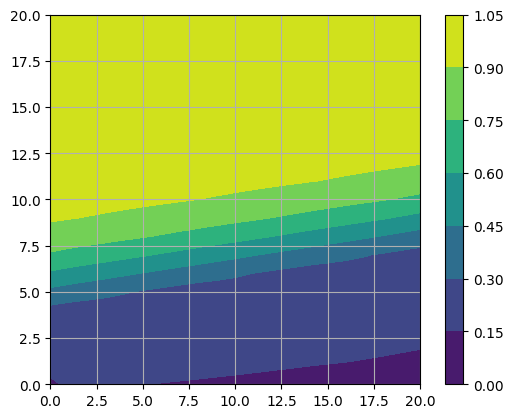

running reward: 0.09 at episode 7500
1.0
1.0


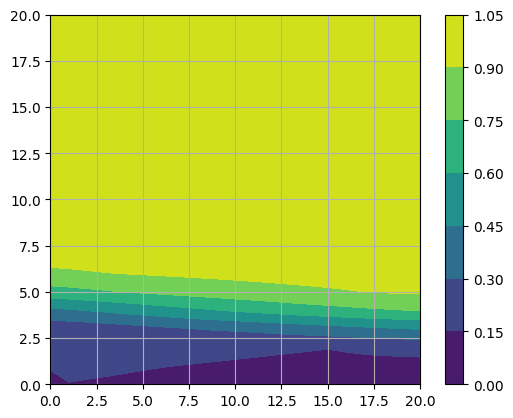

running reward: -0.69 at episode 8000
1.0
1.0


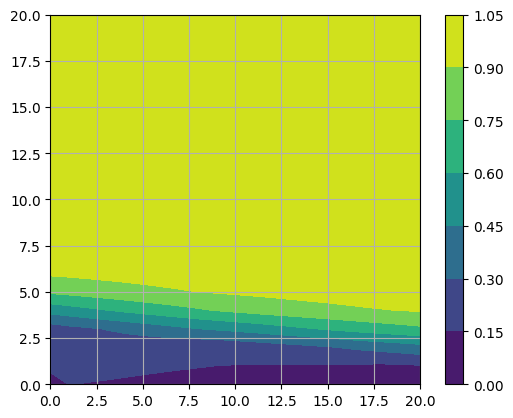

running reward: -0.37 at episode 8500
0.11
0.11


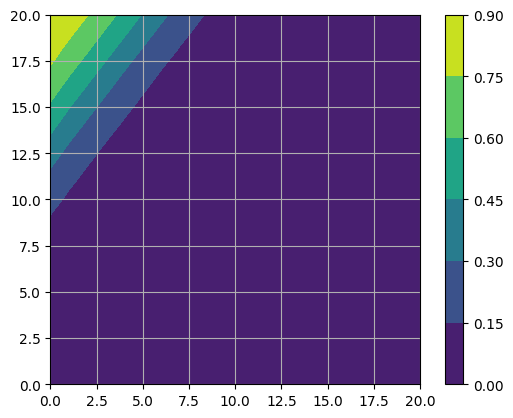

running reward: 0.03 at episode 9000
1.0
1.0


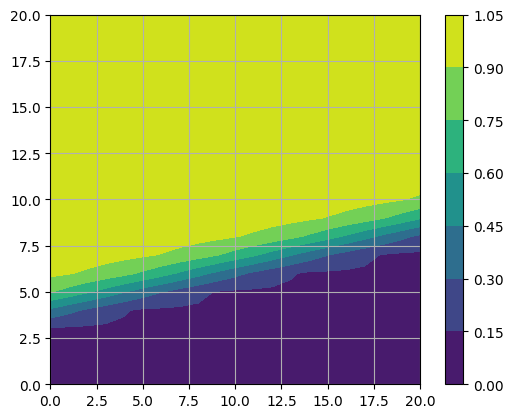

Solved at episode 9481!


In [ ]:
while True:  # Run until solved
    state = env.reset()

    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, 3):
            
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)


            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value)


            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            
            #print(state)
            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward
            action_probs_history.append(tf.math.log(action_probs[0, action]))
            #print(action,state, reward, done)
            
            if done:

                break

        # Update running reward to check condition for solving
        running_reward = 0.1 * episode_reward + (1 - 0.1) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 500 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))
        stan=[19,10,0]
        stan = tf.convert_to_tensor(stan)
        stan = tf.expand_dims(stan, 0)
        probs,ac=model(stan)
        print(round(float(probs[0][0]),2))
        stan=[10,9,0]
        stan = tf.convert_to_tensor(stan)
        stan = tf.expand_dims(stan, 0)
        probs,ac=model(stan)
        print(round(float(probs[0][0]),2))
    
    if episode_count %500 ==0:
        Z=[]
        X=np.linspace(0,20,21)
        Y=np.linspace(0,20,21)
        XY=np.meshgrid(X,Y,sparse=True)
        Z=np.zeros((21,21))

        for x in X:
          for y in Y:
            x=int(x); y=int(y)
            Z[x][y]=res(x,y)

        plt.contourf(X, Y, Z)

        plt.axis('scaled')
        #plt.clim(0,1)
        plt.grid()
        plt.colorbar(boundaries=[0,0.5,1])

        plt.show()




    if running_reward > 0.5:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

 


Chcecking probabilities of pass/play in certain conditions described as stan [player values, dealer values, ace]


and saving the trained model

In [ ]:
stan=[1,14,0]
stan = tf.convert_to_tensor(stan)
stan = tf.expand_dims(stan, 0)
probs,ac=model(stan)
print(float(probs[0][0]))
model.save('model_1.h5')

0.059633009135723114


generating final decision plots

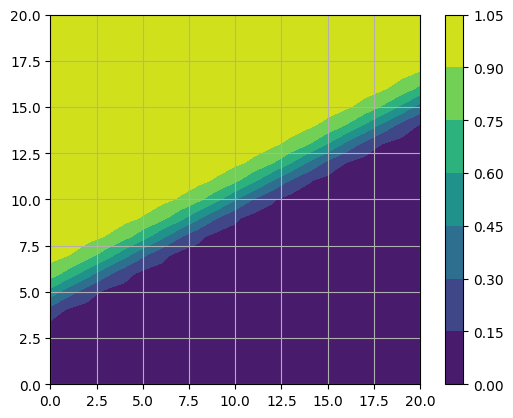

In [ ]:
#generating system
Z=[]
X=np.linspace(0,20,21)
Y=np.linspace(0,20,21)
XY=np.meshgrid(X,Y,sparse=True)
Z=np.zeros((21,21))
def res(x,y):
    stan=[x,y,0]
    stan = tf.convert_to_tensor(stan)
    stan = tf.expand_dims(stan, 0)
    probs,ac=model(stan)
    return float(probs[0][0])
for x in X:
  for y in Y:
    x=int(x); y=int(y)
    Z[x][y]=res(x,y)

plt.contourf(X, Y, Z)

plt.axis('scaled')
plt.grid()
plt.colorbar()

plt.show()

SECOND PART:
https://colab.research.google.com/drive/1G3SyFYg3cfdqFV-fKtS1ERRNuVqAEBVD